## School project - 5DEEP
The following notebook has been created for a school project on audio classification. The subject and the questions are available in the appendix.

The group members who participated in this project are:
- BEZIN Théo
- AMIMI Lamine
- LECOMTE Alexis
- PAWLOWSKI Maxence

### Main index
1. Data analysis
2. Data preprocessing
3. Basic ANN model
4. The CNN model
5. Testing our best model
6. **Data augmentation (you are here)**

# 6 - Data augmentation
Data augmentation is a technique used to increase the diversity of a dataset by modifying existing samples. In this notebook, we will discuss augmentation methods and try this new dataset on two of our previous models.

### Index
<ol type="A">
  <li>Notebook initialization</li>
  <li>Augmentation techniques</li>
  <li>Processing the augmented dataset</li>
  <li>Data preparation</li>
  <li>Testing the augmented data : The ANN</li>
  <li>Testing the augmented data : The CNN</li>
  <li>Conclusion of the data augmentation</li>
</ol>

## A - Notebook initialization
### A.1 - Imports

In [19]:
# OS and filesystem
import os
import sys
from pathlib import Path

# Math
import numpy

# Data
import pandas
from matplotlib import pyplot

# Sound processing
import librosa
import librosa.display
import soundfile
import audiomentations

# Model processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Console output
from colorama import Style
from tqdm.notebook import tqdm

# Misc.
import typing

# Local files
sys.path.append(os.path.join(os.pardir, os.pardir))
import helpers

### A.2 - Package initialization

In [3]:
pyplot.style.use("ggplot")  # Set the matplotlib style
keras.backend.set_image_data_format("channels_last")  # Define the last value of the model input shape as the color channel

### A.3 - Constants

In [4]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = (PARENT_FOLDER / ".." / ".." / "data").resolve()
URBAN_DATASET_FOLDER = DATA_FOLDER / "UrbanSound8K"
MODELS_FOLDER = (PARENT_FOLDER / ".." / ".." / "models").resolve()
TEMP_FOLDER = (PARENT_FOLDER / ".." / ".." / "temp").resolve()

# Dataset
CLASSES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]
N_MELS = 128

# Misc.
RANDOM_STATE = 2077

### A.4 - Dataset loading

In [5]:
data = pandas.read_csv(URBAN_DATASET_FOLDER / "metadata" / "UrbanSound8K.csv")
print(f"{data.shape[0]} rows, {data.shape[1]} columns")
data.head(n=5)

8732 rows, 8 columns


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## B - Augmentation techniques
We augment a dataset by applying small transformations to the existing data. A data sample resulting from the augmentation transformations has the same class as the original sample, but the model perceives them as two different samples. When working with audio data, there are two main ways to augment the data. We can transform the raw audio samples, or the resulting spectrogram.

### B.1 - Raw audio augmentation
There are many techniques to augment raw audio data and most of them are implemented in the `audiomentations` package. We will only describe the transformation functions we used, the [documentation](https://iver56.github.io/audiomentations/) contains more information. You can also listen to the effects of the transformations on [this website](https://phrasenmaeher-audio-transformat-visualize-transformation-5s1n4t.streamlit.app/).

The pipeline can start with four different composers: `Compose`, `SpecCompose`, `OneOf` and `SomeOf`. We chose the `SomeOf` composer with a number of transformations in the range $[1, all]$.
1. **[AddGaussianNoise](https://iver56.github.io/audiomentations/waveform_transforms/add_gaussian_noise/):** This transformation adds noise (random amplitude data) to the audio file. It produces an effect similar to that of a poor quality microphone.
2. **[TimeStretch](https://iver56.github.io/audiomentations/waveform_transforms/time_stretch/):** It changes the speed of the audio without changing the pitch.
3. **[PitchShift](https://iver56.github.io/audiomentations/waveform_transforms/pitch_shift/):** Applies a pitch variation to the signal without changing the tempo.
4. **[Shift](https://iver56.github.io/audiomentations/waveform_transforms/shift/):** Shifts the samples forward or backward. Most of our dataset is composed of sounds in which the order doesn't really matter, unlike a human speaking. In this situation we can set the `rollover` parameter to true without affecting the understanding of the audio file.

In [8]:
augment_pipeline = audiomentations.SomeOf(num_transforms=(1, None), transforms=[
    audiomentations.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    audiomentations.TimeStretch(min_rate=0.8, max_rate=1.25, leave_length_unchanged=True, p=0.5),
    audiomentations.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    audiomentations.Shift(min_fraction=-0.5, max_fraction=0.5, rollover=True, fade=False, p=0.5)
])

### B.2 - Spectrogram augmentation
The second augmentation technique consists in applying a series of masks on a Mel spectrogram.

- Frequency masking is achieved by randomly overwriting lines with null data.
- Time masking is done in the same way as frequency masking, but this time by deleting columns.

For now, we only use the raw data augmentation. It may be interesting in the future to compare model performance between raw augmentation, spectrogram augmentation, and both augmentations at the same time.

## C - Processing the augmented dataset
It is time to apply our augmentation pipeline to the dataset. This will produce a second dataset of the same shape, doubling our data count. Each augmented file will be saved on the disk, in a new folder.

In [10]:
def apply_augmentation(df: pandas.DataFrame, pipeline: typing.Any) -> pandas.DataFrame:
    augmented_data = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Augmenting the dataset..."):
        # Load the audio file and augment it
        samples, sampling_rate = helpers.urban_df.load_audio(dataset_folder=URBAN_DATASET_FOLDER, fold=row["fold"], file_name=row["slice_file_name"])
        samples_augmented = pipeline(samples=samples, sample_rate=sampling_rate)

        # Save the audio file
        save_folder = (URBAN_DATASET_FOLDER / "audio_augmented" / f"fold{row['fold']}")
        save_folder.mkdir(parents=True, exist_ok=True)
        soundfile.write(file=(save_folder / row["slice_file_name"]), data=samples_augmented, samplerate=sampling_rate)

        # Append the augmented data to the list
        row_dict = row.to_dict()
        row_dict["augmented"] = True
        augmented_data.append(row_dict)

    return pandas.DataFrame(augmented_data)


augmented_df = apply_augmentation(df=data, pipeline=augment_pipeline)

Augmenting the dataset...:   0%|          | 0/8732 [00:00<?, ?it/s]

/home/spoonoverlord/miniconda3/envs/5DEEP/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)


We merge the original data set with our augmented set. We also added an `augmented` column to keep information about the data that was obtained by augmentation.

In [11]:
data["augmented"] = False
data_augmented = pandas.concat([data, augmented_df])

print(f"{Style.BRIGHT}Initial dataset:{Style.RESET_ALL} {data.shape}")
print(f"{Style.BRIGHT}Augmented dataset:{Style.RESET_ALL} {data_augmented.shape}")

Initial dataset: (8732, 9)
Augmented dataset: (17464, 9)


The processing of the augmentation is quite time-consuming. We save the dataset before feature extraction for later use.

In [12]:
data_augmented.to_csv(URBAN_DATASET_FOLDER / "metadata" / "UrbanSound8K_augmented.csv")

### C.1 - Feature extraction
We need to rerun the feature extraction with the augmented dataset to construct the Mel spectrogram of the new data.

In [13]:
def extract_features(df: pandas.DataFrame, n_mels: int = N_MELS, duration_sec: int = None) -> pandas.DataFrame:
    features_list = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting features..."):
        # Extract features
        class_label = row["class"]
        mel = helpers.audio.make_mel_spectrogram(dataset_folder=URBAN_DATASET_FOLDER, row=row, n_mels=n_mels, duration_sec=duration_sec)
        augmented = row["augmented"]

        # Append to the features list
        features_list.append([class_label, mel, augmented])

    return pandas.DataFrame(features_list, columns=["class", "mel", "augmented"])


features_augmented = extract_features(df=data_augmented, n_mels=N_MELS, duration_sec=4)

Extracting features...:   0%|          | 0/17464 [00:00<?, ?it/s]

We can now plot the Mel spectrogram of one of the augmented data. We can see that the augmented data produces a similar result to the one obtained in the second notebook with the unmodified dataset.

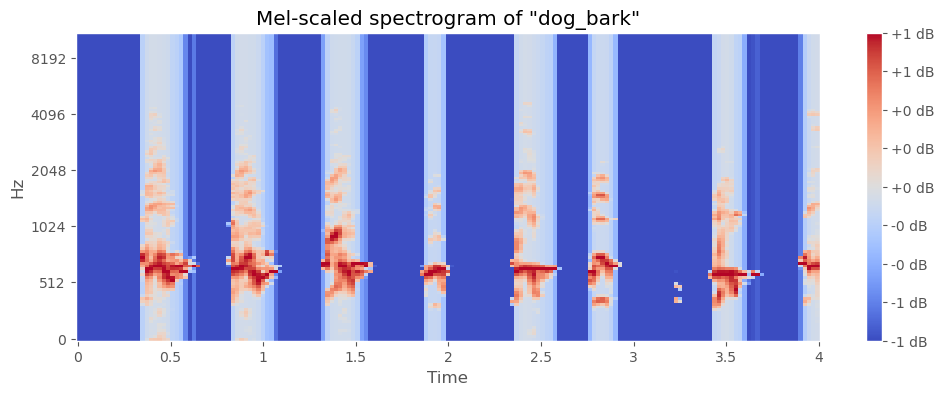

In [15]:
def plot_random_feature(features_df: pandas.DataFrame, fig_size: tuple[float, float] = (12, 4)) -> None:
    random_feature = features_df.sample(n=1).iloc[0]

    fig, ax = pyplot.subplots(figsize=fig_size)
    _ = librosa.display.specshow(random_feature["mel"], x_axis="time", y_axis="mel", ax=ax)
    pyplot.colorbar(ax.get_children()[0], format="%+2.0f dB", ax=ax)
    pyplot.title(f"Mel-scaled spectrogram of \"{random_feature['class']}\"")
    pyplot.show()


plot_random_feature(features_augmented[features_augmented["augmented"] == True])

For exactly the same reason as for data augmentation, we save the augmented features on disk for later use without the need to reprocess them.

In [16]:
features_augmented_x = numpy.array(features_augmented["mel"].tolist())
features_augmented_y = numpy.array(features_augmented["class"].tolist())

features_augmented.to_csv(DATA_FOLDER / "features-augmented-mel-spectrograms_15-02-23_19-21.csv")  # Save the whole dataset ...
numpy.save(file=str(DATA_FOLDER / "x-augmented-mel-spectrograms_15-02-23_19-21"), arr=features_augmented_x)  # ... and the split [x, y] versions
numpy.save(file=str(DATA_FOLDER / "y-augmented-mel-spectrograms_15-02-23_19-21"), arr=features_augmented_y)

We can then reload the augmented dataset with the following code.

In [17]:
features_augmented_x = numpy.load(file=(str(DATA_FOLDER / "x-augmented-mel-spectrograms_15-02-23_19-21.npy")))
features_augmented_y = numpy.load(file=(str(DATA_FOLDER / "y-augmented-mel-spectrograms_15-02-23_19-21.npy")))

## D - Data preparation
### D.1 - Label encoding

In [20]:
label_encoder = LabelEncoder()
features_augmented_y = keras.utils.to_categorical(y=label_encoder.fit_transform(features_augmented_y), num_classes=len(CLASSES))

### D.2 - Dataset splitting

In [21]:
x_aug_train, x_aug_test, y_aug_train, y_aug_test = train_test_split(features_augmented_x, features_augmented_y, test_size=0.2, random_state=RANDOM_STATE)

print(f"{Style.BRIGHT}Train set >{Style.RESET_ALL} rows: (x={len(x_aug_train)}, y={len(y_aug_train)}) | shape: (x={x_aug_train.shape}, y={y_aug_train.shape})")
print(f"{Style.BRIGHT}Test set >{Style.RESET_ALL} rows: (x={len(x_aug_test)}, y={len(y_aug_test)}) | shape: (x={x_aug_test.shape}, y={y_aug_test.shape})")

Train set > rows: (x=13971, y=13971) | shape: (x=(13971, 128, 173), y=(13971, 10))
Test set > rows: (x=3493, y=3493) | shape: (x=(3493, 128, 173), y=(3493, 10))


In [22]:
num_columns = 173
num_channels = 1

x_aug_train = x_aug_train.reshape(x_aug_train.shape[0], N_MELS, num_columns, num_channels)
x_aug_test = x_aug_test.reshape(x_aug_test.shape[0], N_MELS, num_columns, num_channels)

## E - Testing the augmented data : The ANN
**TODO**

### E.1 - Loading our best model
### E.2 - Training
### E.3 - Model performance

## F - Testing the augmented data : The CNN
**TODO**

### F.1 - Loading our best model
### F.2 - Training
### F.3 - Model performance

## G - Conclusion of the data augmentation